# Importing Libraries

In [131]:
# Importing necessary libraries for data manipulation
import pandas as pd
import numpy as np
import os
import PIL
from PIL import Image
from collections import defaultdict

# Importing TensorFlow for machine learning
import tensorflow as tf

# Efficient Looping
import itertools

# Diagnostics
import traceback
from concurrent.futures import ThreadPoolExecutor

# Importing libraries for data visualization
import plotly.graph_objs as go
import plotly.express as px
import plotly.subplots as sp
import plotly.figure_factory as ff
import plotly.io as pio
from IPython.display import display

# Importing libraries for statistical analysis
import scipy.stats as stats
import statsmodels.api as sm
import math

# Importing libraries for feature selection
from sklearn.feature_selection import (
    RFECV, SelectKBest, chi2, f_classif, f_regression,
    mutual_info_classif, mutual_info_regression
)

# Importing libraries for creating machine learning pipelines
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    RobustScaler, StandardScaler, QuantileTransformer, FunctionTransformer
)

# Importing libraries for model selection and cross validation
from sklearn.model_selection import (
    StratifiedKFold, KFold, RepeatedKFold, RepeatedStratifiedKFold,
    train_test_split, TimeSeriesSplit
)

# Importing libraries for machine learning metrics
from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error, 
    cohen_kappa_score, make_scorer, roc_curve, auc,
    accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
)

# Importing machine learning models
from sklearn.linear_model import ( 
    LogisticRegression, RidgeClassifier, HuberRegressor, 
    RANSACRegressor, TheilSenRegressor, Ridge, Lasso, ElasticNet
)
from sklearn.svm import SVR, NuSVR, LinearSVC, SVC
from sklearn.ensemble import (
    HistGradientBoostingRegressor, StackingRegressor, AdaBoostRegressor,
    RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor,
    VotingRegressor, HistGradientBoostingClassifier, AdaBoostClassifier, 
    RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, 
    ExtraTreesClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans

# Importing randomizer
import random

# Importing encoders for categorical variables
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# Importing warnings to ignore them
import warnings
warnings.filterwarnings("ignore")

# Importing seaborn for data visualization
import seaborn as sns

# Configuring notebook
seed = 123
paper_color = '#FF5733'
bg_color = '#FF5733'

# Inilising GPU

In [132]:
# Import the TensorFlow library
import tensorflow as tf

# Get a list of all available GPUs
available_gpus = tf.config.list_physical_devices('GPU')

# Check if any GPUs are available
if available_gpus:
    try:
        # Enable memory growth for each GPU
        for gpu_device in available_gpus:
            tf.config.experimental.set_memory_growth(gpu_device, True)
        
        # Set the first GPU as the visible device
        tf.config.experimental.set_visible_devices(available_gpus[0], 'GPU')
        
        # Create a strategy to distribute the variables and the model on one device
        strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")  
        
        print('\nGPU Found! Using GPU...')
    except RuntimeError as runtime_error:
        print(runtime_error)
else:
    # If no GPUs are available, get the default distribution strategy
    strategy = tf.distribute.get_strategy()
    
    print('Number of replicas:', strategy.num_replicas_in_sync)


GPU Found! Using GPU...


# Import DataSet


link for the dataset:https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset

In [133]:
# Loading training, testing, and validation directories
train_dir = r'\Dataset\Train'
test_dir = r'\Dataset\Test'
val_dir = r'\Dataset\Validation'

In [ ]:
train_dir, test_dir, val_dir

In [135]:
dir_names = {
    train_dir: 'Training',
    test_dir: 'Testing',
    val_dir: 'Validating'
}

# Defining subfolders
subfolder_names = ['Healthy', 'Powdery', 'Rust']

## Inspecting the files 

In [136]:
import os

def calculate_file_counts(directory_dict, subfolder_list):
    result = {}  # Initialize an empty dictionary to store the results

    # Iterate over each directory and its name in the provided dictionary
    for directory_path, directory_name in directory_dict.items():
        total_file_count = 0  # Initialize a counter for the total number of files in the directory
        directory_result = {}  # Initialize an empty dictionary to store the results for this directory

        # Iterate over each subfolder in the provided list
        for subfolder in subfolder_list:
            # Join the directory path and the subfolder name to get the full path of the subfolder
            subfolder_path = os.path.join(str(directory_path), subfolder)

            try:
                # Count the number of files in the subfolder
                subfolder_file_count = len([file for file in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, file))])

                # Add the number of files in the subfolder to the total file count
                total_file_count += subfolder_file_count

                # Add the subfolder file count to the directory result
                directory_result[subfolder] = subfolder_file_count
            except FileNotFoundError:
                print(f'Directory {subfolder_path} not found')

        # Add the total file count to the directory result
        directory_result['Total files'] = total_file_count

        # Add the directory result to the overall result
        result[directory_name] = directory_result

    return result

file_counts = calculate_file_counts(dir_names, subfolder_names)


In [137]:
for directory, counts in file_counts.items():
    print(f"Directory: {directory}")
    for subfolder, count in counts.items():
        print(f"  Subfolder: {subfolder}, File Count: {count}")

Directory: Training
  Subfolder: Healthy, File Count: 458
  Subfolder: Powdery, File Count: 430
  Subfolder: Rust, File Count: 434
  Subfolder: Total files, File Count: 1322
Directory: Testing
  Subfolder: Healthy, File Count: 50
  Subfolder: Powdery, File Count: 50
  Subfolder: Rust, File Count: 50
  Subfolder: Total files, File Count: 150
Directory: Validating
  Subfolder: Healthy, File Count: 20
  Subfolder: Powdery, File Count: 20
  Subfolder: Rust, File Count: 20
  Subfolder: Total files, File Count: 60


## Checking the dimesion 

In [138]:
# Import necessary libraries
from collections import defaultdict
from PIL import Image
import os

# Define a function to inspect and count image dimensions
def inspect_and_count_image_dimensions(directory_dict, subfolder_list):
    # Initialize a set to store distinct image sizes
    distinct_sizes = set()
    # Initialize a dictionary to count the occurrences of each image size
    dimension_counts = defaultdict(int)

    # Loop over each directory and its name in the provided dictionary
    for directory_path, directory_name in directory_dict.items():
        # Loop over each subfolder in the provided list
        for subfolder in subfolder_list:
            # Construct the path to the subfolder
            subfolder_path = os.path.join(directory_path, subfolder)
            
            # Loop over each file in the subfolder
            for filename in os.listdir(subfolder_path):
                # Construct the path to the image file
                img_path = os.path.join(subfolder_path, filename)
                # Open the image file
                with Image.open(img_path) as image:
                    # Add the image size to the set of distinct sizes
                    distinct_sizes.add(image.size)
                    # Increment the count for this image size
                    dimension_counts[image.size] += 1

    # Initialize an empty dictionary to store the results
    result = {}

    # If all images have the same size, store that size
    if len(distinct_sizes) == 1:
        result["Same dimensions"] = list(distinct_sizes)[0]
    # Otherwise, store the list of unique sizes
    else:
        result["Unique dimensions"] = list(distinct_sizes)

    # Convert the dimension counts to a dictionary with string keys
    dimension_counts_dict = {str(k): v for k, v in dimension_counts.items()}
    # Store the dimension counts in the result dictionary
    result["Dimension counts"] = dimension_counts_dict

    # Return the result dictionary
    return result

In [139]:
image_info = inspect_and_count_image_dimensions(dir_names, subfolder_names)

for key, value in image_info.items():
    print(f"{key}:")
    if isinstance(value, dict):
        for sub_key, sub_value in value.items():
            print(f"  {sub_key}: {sub_value}")
    else:
        print(f"  {value}")

Unique dimensions:
  [(4032, 3024), (4000, 2672), (4000, 3000), (5184, 3456), (2592, 1728), (3901, 2607), (4608, 3456), (2421, 2279)]
Dimension counts:
  (4000, 3000): 88
  (4000, 2672): 1130
  (2421, 2279): 1
  (2592, 1728): 127
  (5184, 3456): 97
  (4608, 3456): 72
  (4032, 3024): 16
  (3901, 2607): 1


## Checking image Data

In [140]:
# Import necessary libraries
import numpy as np
from PIL import Image
import os

# Define a function to check the data type and range of pixel values of images
def check_image_dtype_and_range(dir_names, subfolder_names):
    # Initialize flags for data type and range checks
    all_uint8 = True
    all_in_range = True

    # Iterate over each directory and its label in the provided dictionary
    for directory, dir_label in dir_names.items():
        # Iterate over each subfolder in the provided list
        for subfolder in subfolder_names:
            # Join the directory path and the subfolder name to get the full path of the subfolder
            subfolder_path = os.path.join(directory, subfolder)
            
            # Iterate over each file in the subfolder
            for filename in os.listdir(subfolder_path):
                # Join the subfolder path and the filename to get the full path of the image
                img_path = os.path.join(subfolder_path, filename)
                # Open the image and convert it to a numpy array
                with Image.open(img_path) as image:
                    image_array = np.array(image)
                    
                # Check if the data type of the image is not uint8
                if image_array.dtype != 'uint8':
                    all_uint8 = False
                
                # Check if the pixel values of the image are outside the range 0 to 255
                if image_array.min() < 0 or image_array.max() > 255:
                    all_in_range = False
                    
    # Print the results of the data type check
    if all_uint8:
        print("All images are of data type uint8.")
    else:
        print("Some images are not of data type uint8.")
        
    # Print the results of the range check
    if all_in_range:
        print("All images have pixel values in the range 0 to 255.")
    else:
        print("Some images have pixel values outside the range 0 to 255.")

# Call the function with the directories and subfolders to check
check_image_dtype_and_range(dir_names, subfolder_names)

All images are of data type uint8.
All images have pixel values in the range 0 to 255.


## Loading Samples

In [141]:
# Import necessary libraries
import os
import random

# Define a function to load and sample images from each class
def load_and_sample_images(train_dir, class_names, sample_size):
    # Initialize a dictionary to store the filenames for each class
    class_files = {}

    # Loop over each class name
    for class_name in class_names:
        # Construct the path to the directory for this class
        class_dir = os.path.join(train_dir, class_name)
        # Randomly sample some filenames from this directory
        class_files[class_name] = random.sample(os.listdir(class_dir), sample_size)

    # Return the dictionary of filenames
    return class_files

# Define the class names and sample size
class_names = ['Healthy', 'Rust', 'Powdery']
sample_size = 6

# Load and sample images from the training, testing, and validation directories
class_train_files = load_and_sample_images(train_dir, class_names, sample_size)
class_test_files = load_and_sample_images(test_dir, class_names, sample_size)
class_validation_files = load_and_sample_images(val_dir, class_names, sample_size)

In [142]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
def display_sampled_images(class_files, base_dir):
    for class_name, files in class_files.items():
        fig, axs = plt.subplots(1, len(files), figsize=(8, 5))
        for i, file in enumerate(files):
            # Join the base directory with the class name and file name to get the full path
            img_path = os.path.join(base_dir, class_name, file)

            # Check if the file exists before attempting to read it 
            if os.path.exists(img_path):
                # Read the image file
                img = mpimg.imread(img_path)
                # Display the image
                axs[i].imshow(img)
                axs[i].set_title(class_name)
                axs[i].axis('off') 
            else:
                print(f"File not found: {img_path}") 


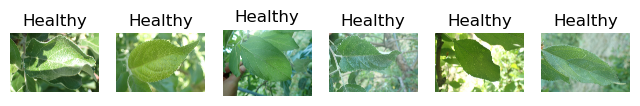

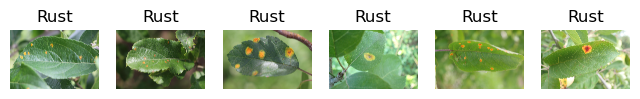

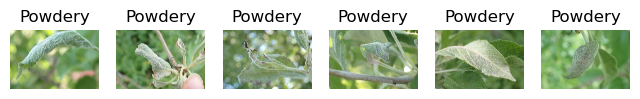

In [143]:
# Display sampled images from the training directory
display_sampled_images(class_train_files, train_dir)


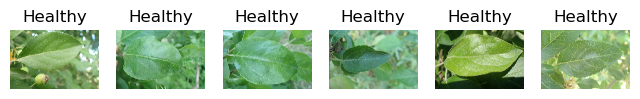

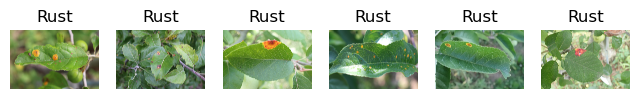

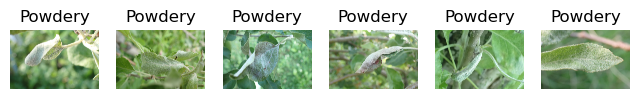

In [144]:
# Display sampled images from the testing directory
display_sampled_images(class_test_files, test_dir)

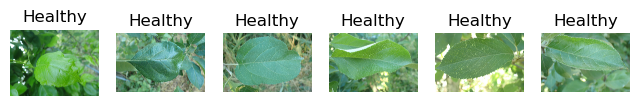

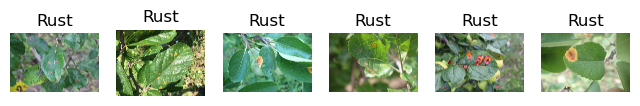

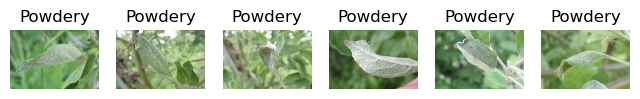

In [145]:
# Display sampled images from the validation directory
display_sampled_images(class_validation_files, val_dir)


## Creating the Dataset

In [146]:
# Define a function to create a dataset from images in a directory
def create_dataset(dir_path, class_names, batch_size, image_size, seed):
    # Use TensorFlow's utility function to create a dataset from the images
    return tf.keras.utils.image_dataset_from_directory(
        dir_path,  # The directory where the images are stored
        labels='inferred',  # Infer the labels from the directory structure
        label_mode='categorical',  # Encode the labels as one-hot vectors
        class_names=class_names,  # The names of the classes
        batch_size=batch_size,  # The size of the batches to generate
        image_size=image_size,  # The size to resize the images to
        shuffle=True,  # Shuffle the data
        seed=seed,  # Seed for shuffling
        validation_split=0,  # Don't split the data into training and validation sets
        crop_to_aspect_ratio=True  # Crop the images to the specified aspect ratio
    )

# Define the class names, batch size, image size, and seed
class_names = ['Healthy', 'Powdery', 'Rust']
batch_size = 8
image_size = (256, 256)
seed = 123

# Create datasets for training, testing, and validation
train = create_dataset(train_dir, class_names, batch_size, image_size, seed)
test = create_dataset(test_dir, class_names, batch_size, image_size, seed)
validation = create_dataset(val_dir, class_names, batch_size, image_size, seed)

Found 1322 files belonging to 3 classes.
Found 150 files belonging to 3 classes.
Found 60 files belonging to 3 classes.


## Image and Label extration

In [147]:
def extract_data_and_labels(dataset):
    # Initialize lists to store the data and labels
    data = []
    labels = []

    # Iterate over the dataset
    for images, labels_batch in dataset:
        data.append(images)
        labels.append(labels_batch)

    # Convert the lists to numpy arrays
    data = np.concatenate(data)
    labels = np.concatenate(labels)

    return data, labels

In [148]:
# Extract data and labels from the datasets
train_data, train_labels = extract_data_and_labels(train)
test_data, test_labels = extract_data_and_labels(test)
validation_data, validation_labels = extract_data_and_labels(validation)

# Preprossing

In [149]:
# Function to check the pixel values in a dataset and rescale them if necessary
def inspect_and_rescale_pixel_values(image_dataset, dataset_name):
    # Initialize the minimum value to infinity
    min_pixel_value = float('inf')
    # Initialize the maximum value to negative infinity
    max_pixel_value = -float('inf')

    # Iterate over each image and label in the dataset
    for image, label in image_dataset:
        # Find the minimum pixel value in the image
        batch_min = tf.reduce_min(image)
        # Find the maximum pixel value in the image
        batch_max = tf.reduce_max(image)

        # Update the overall minimum value if necessary
        min_pixel_value = min(min_pixel_value, batch_min.numpy())
        # Update the overall maximum value if necessary
        max_pixel_value = max(max_pixel_value, batch_max.numpy())

    # Print the minimum and maximum pixel values in the dataset
    print('\nMinimum pixel value :', dataset_name, min_pixel_value)
    print('\nMaximum pixel value :', dataset_name, max_pixel_value)

    # Return the dataset (this function could be modified to rescale the pixel values if necessary)
    return image_dataset

# Check the pixel values in the validation dataset and rescale them if necessary
validation_dataset = inspect_and_rescale_pixel_values(validation, 'Validation')
# Check the pixel values in the training dataset and rescale them if necessary
training_dataset = inspect_and_rescale_pixel_values(train, 'Training')
# Check the pixel values in the testing dataset and rescale them if necessary
testing_dataset = inspect_and_rescale_pixel_values(test, 'Testing')





Minimum pixel value : Validation 0.0

Maximum pixel value : Validation 255.0

Minimum pixel value : Training 0.0

Maximum pixel value : Training 255.0

Minimum pixel value : Testing 0.0

Maximum pixel value : Testing 255.0


In [150]:
# Import the TensorFlow library
import tensorflow as tf

# Define a function to scale images in a dataset
def scale_images(dataset, datasetname):
    # Initialize the minimum and maximum pixel values
    min_value = float('inf')
    max_value = -float('inf')

    # Define a rescaling layer that scales pixel values to the range [0, 1]
    rescale = tf.keras.layers.Rescaling(1./255)

    # Apply the rescaling layer to the images in the dataset
    rescaled_dataset = dataset.map(lambda x, y: (rescale(x), y))

    # Loop over each image and label in the rescaled dataset
    for img, label in rescaled_dataset:
        # Compute the minimum and maximum pixel values in the image
        batch_min = tf.reduce_min(img)
        batch_max = tf.reduce_max(img)

        # Update the overall minimum and maximum pixel values
        min_value = min(min_value, batch_min.numpy())
        max_value = max(max_value, batch_max.numpy())

    # Print the minimum and maximum pixel values in the rescaled dataset
    print('\nMinimum pixel value in normalised dataset', datasetname, min_value)
    print('\nMaximum  pixel value in normalised dataset', datasetname, max_value)

    # Return the rescaled dataset
    return rescaled_dataset

# Scale the images in the validation, training, and testing datasets
validation = scale_images(validation, 'Validation')
train = scale_images(train, "train")   
test = scale_images(test, "test")


Minimum pixel value in normalised dataset Validation 0.0

Maximum  pixel value in normalised dataset Validation 1.0

Minimum pixel value in normalised dataset train 0.0

Maximum  pixel value in normalised dataset train 1.0

Minimum pixel value in normalised dataset test 0.0

Maximum  pixel value in normalised dataset test 1.0


## Create Augmentataion Pipeline

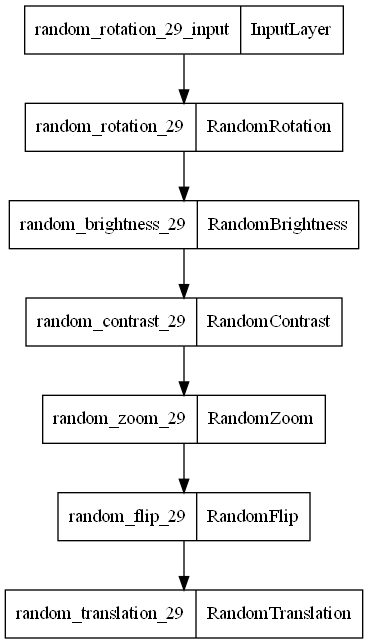

In [151]:
# Define a function to create an augmentation pipeline
def create_augmentation_pipeline(seed, input_shape=(None, 256, 256, 3)):
    # Create a sequential model for the augmentation pipeline
    augmentation = tf.keras.Sequential(
        [
            # Add a layer to randomly rotate the images
            tf.keras.layers.RandomRotation(
                factor=(-.25, .3),  # The range of rotation angles
                fill_mode='reflect',  # How to fill the empty space caused by the rotation
                interpolation='bilinear',  # The interpolation method
                seed=seed),  # The random seed

            # Add a layer to randomly adjust the brightness of the images
            tf.keras.layers.RandomBrightness(
                factor=(-.45, .45),  # The range of brightness factors
                value_range=(0.0, 1.0),  # The range of pixel values
                seed=seed),  # The random seed

            # Add a layer to randomly adjust the contrast of the images
            tf.keras.layers.RandomContrast(
                factor=(.5),  # The contrast factor
                seed=seed),  # The random seed

            # Add a layer to randomly zoom the images
            tf.keras.layers.RandomZoom(
                height_factor=(-0.2, 0.2),  # The range of height zoom factors
                width_factor=(-0.2, 0.2),  # The range of width zoom factors
                fill_mode='reflect',  # How to fill the empty space caused by the zoom
                interpolation='bilinear',  # The interpolation method
                seed=seed),  # The random seed

            # Add a layer to randomly flip the images
            tf.keras.layers.RandomFlip(
                mode='horizontal_and_vertical',  # The flip mode
                seed=seed),  # The random seed

            # Add a layer to randomly translate the images
            tf.keras.layers.RandomTranslation(
                height_factor=(-0.2, 0.2),  # The range of height translation factors
                width_factor=(-0.2, 0.2),  # The range of width translation factors
                fill_mode='reflect',  # How to fill the empty space caused by the translation
                interpolation='bilinear',  # The interpolation method
                seed=seed)  # The random seed
        ]
    )

    # Build the augmentation model
    augmentation.build(input_shape)

    # Plot the model architecture
    tf.keras.utils.plot_model(augmentation,
                              show_shapes=True,  # Show the shapes of the tensors
                              show_layer_names=True,  # Show the names of the layers
                              expand_nested=True)  # Expand nested models

    # Return the augmentation model
    return augmentation

# Create the augmentation pipeline
augmentation = create_augmentation_pipeline(seed)

# Plot the model architecture
tf.keras.utils.plot_model(augmentation)

# CNN Models

## VGG-16 Model

In [152]:
from tensorflow.keras.models import Sequential
# Define a function to create a VGG16 model
def VGG16_model():
    # Start a new scope for the model
    with strategy.scope():
        # Initialize a sequential model
        model = Sequential()

        # Add a 2D convolution layer with 32 filters, a 3x3 kernel, and padding
        model.add(Conv2D(32, (3,3), strides = 1, padding = 'same', input_shape = (256,256,3)))
        # Add a ReLU activation layer
        model.add(Activation('relu'))
        # Add a batch normalization layer
        model.add(BatchNormalization())
        # Add a 2D max pooling layer with a 2x2 pool size and padding
        model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
        # Add a dropout layer with a dropout rate of 0.2
        model.add(Dropout(0.2))

        # Repeat the above steps with different parameters
        model.add(Conv2D(64, (5,5), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
        model.add(Dropout(0.2))

        model.add(Conv2D(128, (3,3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
        model.add(Dropout(0.3))

        model.add(Conv2D(256, (5,5), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
        model.add(Dropout(0.3))

        model.add(Conv2D(512, (3,3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
        model.add(Dropout(0.3))

        # Flatten the tensor output from the previous layer
        model.add(Flatten())

        # Add a fully connected layer with 2048 units
        model.add(Dense(2048))
        # Add a ReLU activation layer
        model.add(Activation('relu'))
        # Add a dropout layer with a dropout rate of 0.5
        model.add(Dropout(0.5))

        # Add an output layer with 3 units (for 3 classes) and a softmax activation function
        model.add(Dense(3, activation = 'softmax'))

        # Compile the model with the Adam optimizer, categorical crossentropy loss, and accuracy metric
        model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

        # Return the model
        return model

# Create the VGG16 model
#model=VGG16_model()

# Print a summary of the model
#model.summary()

# Plot the model architecture
#tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

## VGG-16 TLModel

In [153]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten

def VGG16_TLmodel():
    with strategy.scope():
        # Load the VGG16 model, ensuring the head FC layer sets are left off
        baseModel = VGG16(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

        # Construct the head of the model that will be placed on top of the base model
        headModel = baseModel.output
        headModel = Flatten(name="flatten")(headModel)
        headModel = Dense(512, activation="relu")(headModel)
        headModel = Dense(3, activation="softmax")(headModel)

        # Place the head FC model on top of the base model (this will become the actual model we will train)
        model = Model(inputs=baseModel.input, outputs=headModel)

        # Loop over all layers in the base model and freeze them so they will not be updated during the first training process
        for layer in baseModel.layers:
            layer.trainable = False

        # Compiling model
        model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
        model.build(input_shape=(256, 256, 3))
      
        
        return model
#model=VGG16_TLmodel()
#model.summary()  

#tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)       

## AlexNet

In [154]:
# Import necessary modules from Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Input

# Define a function to create an AlexNet model
def AlexNet_model():
    # Start a new scope for the model
    with strategy.scope():
        # Define the input tensor shape
        input_tensor = Input(shape=(256, 256, 3))
   
        # Initialize a sequential model
        model = Sequential()

        # Layer 1: Convolutional layer with 96 filters, 11x11 kernel, followed by BatchNorm, ReLU activation, MaxPooling and Dropout
        model.add(Conv2D(96, (11, 11), input_shape=(256, 256, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))  # Added Dropout layer

        # Layer 2: Convolutional layer with 256 filters, 5x5 kernel, followed by BatchNorm, ReLU activation, MaxPooling and Dropout
        model.add(Conv2D(256, (5, 5), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))  # Added Dropout layer

        # Layer 3: Convolutional layer with 384 filters, 3x3 kernel, followed by BatchNorm, ReLU activation, and MaxPooling
        model.add(Conv2D(384, (3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        # Layer 4: Convolutional layer with 384 filters, 3x3 kernel, followed by BatchNorm and ReLU activation
        model.add(Conv2D(384, (3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        # Layer 5: Convolutional layer with 256 filters, 3x3 kernel, followed by BatchNorm, ReLU activation, and MaxPooling
        model.add(Conv2D(256, (3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        # Layer 6: Flatten layer followed by Dense layer with 4096 units, BatchNorm, ReLU activation, and Dropout
        model.add(Flatten())
        model.add(Dense(4096, input_shape=(256*256*3,)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.4))

        # Layer 7: Dense layer with 4096 units, followed by BatchNorm, ReLU activation, and Dropout
        model.add(Dense(4096))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.4))

        # Layer 8: Dense layer with 1000 units, followed by BatchNorm, ReLU activation, and Dropout
        model.add(Dense(1000))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.4))

        # Layer 9: Output Dense layer with 3 units (for 3 classes), followed by BatchNorm and softmax activation
        model.add(Dense(3))
        model.add(BatchNormalization())
        model.add(Activation('softmax'))

        # Compile the model with the Adam optimizer, categorical crossentropy loss, and accuracy metric
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Build the model
        model.build()

    # Return the model
    return model

# Create the AlexNet model
#model=AlexNet_model()

# Print a summary of the model
#model.summary()      

# Plot the model architecture
#tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

## Resnet Model

In [155]:
# Import necessary modules from Keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.layers import ReLU, Input

# Define a function to create a ResNet model
def Reset_model():
    # Start a new scope for the model
    with strategy.scope():
        # Define a function for a ResNet block
        def resnet_block(x, out_channels, first_stride=1):
            # Set padding for the first convolutional layer
            first_padding = 'same'
            if first_stride != 1:
                first_padding = 'valid'

            # First convolutional layer
            x = Conv2D(out_channels, 3, first_stride, padding=first_padding)(x)
            # Batch normalization layer
            x = BatchNormalization()(x)
            # ReLU activation layer
            x = ReLU()(x)

            # Second convolutional layer
            x = Conv2D(out_channels, 3, 1, padding='same')(x)
            # Batch normalization layer
            x = BatchNormalization()(x)
            # ReLU activation layer
            x = ReLU()(x)

            # Return the output tensor
            return x

        # Define the input tensor shape
        input_tensor = Input(shape=(256, 256, 3))

        # Initial convolutional layer
        x = Conv2D(64, 7, 2)(input_tensor)
        # ReLU activation layer
        x = ReLU()(x)
        # Max pooling layer
        x = MaxPooling2D(3, 2)(x)

        # Add ResNet blocks with different parameters
        for out_channels, first_stride in [(64, 1), (64, 1), (128, 2), (128, 1), (256, 2), (256, 1), (512, 2), (512, 1)]:
            x = resnet_block(x, out_channels, first_stride)

        # Global average pooling layer
        x = GlobalAveragePooling2D()(x)
        # Output layer with 3 units (for 3 classes) and a softmax activation function
        x = Dense(3, activation='softmax')(x)

        # Define the model with the specified inputs and outputs
        model = Model(inputs=input_tensor, outputs=x)
        # Compile the model with the Adam optimizer, categorical crossentropy loss, and accuracy metric
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Return the model
    return model

# Create the ResNet model
#model=Reset_model()

# Print a summary of the model
##model.summary()

# Plot the model architecture
#tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

## ResNet TL_Model

In [156]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

def Reset_TLmodel():
    with strategy.scope():
        # Load the ResNet50 model, ensuring the head FC layer sets are left off
        baseModel = ResNet50(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

        # Construct the head of the model that will be placed on top of the base model
        headModel = baseModel.output
        headModel = Flatten(name="flatten")(headModel)
        headModel = Dense(512, activation="relu")(headModel)
        headModel = Dense(3, activation="softmax")(headModel)

        # Place the head FC model on top of the base model (this will become the actual model we will train)
        model = Model(inputs=baseModel.input, outputs=headModel)

        # Loop over all layers in the base model and freeze them so they will not be updated during the first training process
        for layer in baseModel.layers:
            layer.trainable = False

        # Compile the model
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        #model.build()
        

        return model
#
#model=Reset_TLmodel()
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

## Inception Model

In [157]:
# Import necessary modules from Keras
from keras.applications import InceptionV3
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.layers import Input

# Define a function to create a transfer learning model using InceptionV3
def Inception_TLmodel():
    # Start a new scope for the model
    with strategy.scope():
        # Define the input tensor shape
        input_tensor = Input(shape=(256, 256, 3))

        # Load the InceptionV3 model with pre-trained weights from ImageNet, excluding the top (output) layer
        inception = InceptionV3(include_top=False, weights='imagenet', input_tensor=input_tensor)

        # Loop through each layer in the InceptionV3 model
        for layer in inception.layers:
            # Set the layer to be non-trainable (weights will not be updated)
            layer.trainable = False

        # Flatten the output tensor of the InceptionV3 model
        x = Flatten()(inception.output)
        # Define the output layer with 3 units (for 3 classes) and a softmax activation function
        pred = Dense(3, activation='softmax')(x)

        # Define the model with the specified inputs and outputs
        model = Model(inputs=input_tensor, outputs=pred)
        # Compile the model with the Adam optimizer, categorical crossentropy loss, and accuracy metric
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
        # Return the model
        return model

# Create the transfer learning model using InceptionV3
#model=Inception_TLmodel()

# Print a summary of the model
#model.summary()

# Helper Funtions

## Plotting and Resizing Tool


In [158]:
# Import necessary modules
from concurrent.futures import ThreadPoolExecutor
from PIL import Image
import plotly.graph_objects as go
import plotly.subplots as sp

# Define a function to resize images
def resize_images(image_paths):
    # Use a ThreadPoolExecutor to perform the resizing operation in parallel
    with ThreadPoolExecutor() as executor:
        # Open each image, resize it to 350x250, and add it to a list
        images_resized = list(executor.map(lambda img_path: Image.open(img_path).resize((350,250)), image_paths))
    # Return the list of resized images
    return images_resized

# Define a function to display a grid of images
def display_image_grid(image_list, main_title, sub_title):
    # Create a 3x3 subplot figure
    subplot_figure = sp.make_subplots(rows=3, cols=3)
    # Resize the images in the list
    image_list = resize_images(image_list)
    
    # Initialize an empty list to hold the image traces
    image_traces = []
    # Loop through the first 9 images in the list
    for idx in range(min(9, len(image_list))):
        # Create an Image trace for the current image
        image = go.Image(z=image_list[idx])
        # Add the Image trace and its position to the list
        image_traces.append((image, idx//3+1, idx%3+1))
        
    # Add the Image traces to the subplot figure at the specified positions
    subplot_figure.add_traces([trace[0] for trace in image_traces],
                  rows = [trace[1] for trace in image_traces],
                  cols = [trace[2] for trace in image_traces])

    # Update the layout of the subplot figure with a title, size, margin, and background color
    subplot_figure.update_layout(
        title={'text': f'<b>{main_title}<br>  <i><sub>{sub_title}</sub></i></b>',
               'font': dict(size = 22)},
        height=800,
        width=800,
        margin=dict(t=110, l=80),
        plot_bgcolor=bg_color, paper_bgcolor=paper_color
    )
    # Display the subplot figure
    subplot_figure.show()

## PlotingGraph Tool

In [159]:
# Import necessary modules from Plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Define a function to plot the training history
def plot_history(history, bg_color, paper_color):
    # Create a subplot figure with 1 row and 2 columns
    fig = make_subplots(rows=1,
                        cols=2,
                        subplot_titles=['<b>Loss Over Epochs</b>', '<b>Accuracy Over Epochs</b>'],
                        horizontal_spacing=0.2)

    # Create a Scatter trace for the training loss
    train_loss = go.Scatter(x=list(range(len(history.history['loss']))),
                            y=history.history['loss'],
                            mode='lines',
                            line=dict(color='rgba(0, 67, 162, .75)', width=4.75),
                            name='Training',
                            showlegend = False)

    # Create a Scatter trace for the validation loss
    val_loss = go.Scatter(x=list(range(len(history.history['val_loss']))),
                          y=history.history['val_loss'],
                          mode='lines',
                          line=dict(color='rgba(255, 132, 0, .75)', width=4.75),
                          name='Test',
                          showlegend = False)

    # Add the Scatter traces to the subplot figure
    fig.add_trace(train_loss, row=1, col=1)
    fig.add_trace(val_loss, row=1, col=1)

    # Create a Scatter trace for the training accuracy
    train_acc = go.Scatter(x=list(range(len(history.history['accuracy']))),
                           y=history.history['accuracy'],
                           mode='lines',
                           line=dict(color='rgba(0, 67, 162, .75)', width=4.75),
                           name='Training',
                           showlegend = True)

    # Create a Scatter trace for the validation accuracy
    val_acc = go.Scatter(x=list(range(len(history.history['val_accuracy']))),
                         y=history.history['val_accuracy'],
                         mode='lines',
                         line=dict(color='rgba(255, 132, 0, .75)', width=4.75),
                         name='Test',
                         showlegend = True)

    # Add the Scatter traces to the subplot figure
    fig.add_trace(train_acc, row=1, col=2)
    fig.add_trace(val_acc, row=1, col=2)

    # Update the layout of the subplot figure
    fig.update_layout(
        title={'text': '<b>Loss and Accuracy Over Epochs</b>', 'x': 0.025, 'xanchor': 'left'},
        margin=dict(t=100),
        plot_bgcolor=bg_color, paper_bgcolor=paper_color,
        height=500, width=1000,
        showlegend= True
    )

    # Update the y-axes titles
    fig.update_yaxes(title_text = 'Loss', row = 1, col = 1)
    fig.update_yaxes(title_text = 'Accuracy', row = 1, col = 2)

    # Update the x-axes titles
    fig.update_xaxes(title_text = 'Epoch', row = 1, col = 1)
    fig.update_xaxes(title_text = 'Epoch', row = 1, col = 2)

    # Display the subplot figure
    fig.show()

# Initilising Models

## Ceating Model Dictonary

In [160]:
# Create a list named 'models' to manage multiple models
models = [
    
    # Each item in the list is a dictionary representing a model
    {
    'name': 'AlexNet_model',            ## The name of the model
    'model_fn': AlexNet_model,          ## The function that creates the model
    'augmentation': augmentation        ## The data augmentation strategy to use
  },
  
  # Repeated the same structure for the VGG16 model
  {
    'name': 'VGG16_model',
    'model_fn': VGG16_model,
    'augmentation': augmentation 
  },
  
  # Repeated the same structure for the VGG16 transfer learning model
  {
    'name': 'VGG16_TLmodel',
    'model_fn': VGG16_TLmodel,
    'augmentation': augmentation 
  },
  
  # Repeated the same structure for the ResNet model
  {
    'name': 'Reset_model',
    'model_fn': Reset_model,
    'augmentation': augmentation 
  },
  
  # Repeated the same structure for the ResNet transfer learning model
  {
    'name': 'Reset_TLmodel',
    'model_fn': Reset_TLmodel,
    'augmentation': augmentation 
  },
  
  # Repeated the same structure for the Inception transfer learning model
  {
    'name': 'Inception_TLmodel',
    'model_fn': Inception_TLmodel,
    'augmentation': augmentation 
  },
]

# model fitting

In [119]:
"""import time
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

# Model training loop with augmentation
for model_info in models:
    print(model_info['name'])

    # Create model with integrated augmentation
    with strategy.scope():  # For GPU usage
        model = model_info['model_fn']()  # Call the model function to create an instance of the model

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Compile the model

        try:
            # Check if augmentation is specified
            augmentation = model_info.get('augmentation', create_augmentation_pipeline(seed))  # Create a default pipeline if not specified

            # Apply augmentation during training
            augmented_train = train.map(
                lambda x, y: (augmentation(x), y),
                num_parallel_calls=tf.data.AUTOTUNE
            )

            # Define the ModelCheckpoint callback
            checkpoint = ModelCheckpoint(f'{model_info["name"]}_best_model.h5', save_best_only=True, monitor='val_accuracy', mode='min')
            early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)

            # Start the timer
            start_time = time.time()

            history = model.fit(
                augmented_train,  # Use augmented dataset
                epochs=10,  
                validation_data=validation,
                callbacks=[early_stopping, checkpoint], 
                verbose=1 
            )

            # End the timer and calculate the elapsed time
            end_time = time.time()
            elapsed_time = end_time - start_time
            print(f"Time taken to fit the model: {elapsed_time} seconds")

            # Plotting the history
            plot_history(history, bg_color, paper_color)

            y_pred = model.predict(train_data)
            y_pred_classes = np.argmax(y_pred, axis=1)

            train_labels_classes = np.argmax(train_labels, axis=1)

            # Generate the confusion matrix
            cm = confusion_matrix(train_labels_classes, y_pred_classes)
            print('Confusion matrix:\n', cm)
            
            # Calculate and print the F1 score
            report = classification_report(train_labels_classes, y_pred_classes)
            print('Classification Report:\n', report)

        except Exception as e:
            print("An error occurred:", e)"""

'import time\nfrom tensorflow.keras.callbacks import ModelCheckpoint\nfrom tensorflow.keras.callbacks import EarlyStopping\nfrom sklearn.metrics import classification_report\n\n# Model training loop with augmentation\nfor model_info in models:\n    print(model_info[\'name\'])\n\n    # Create model with integrated augmentation\n    with strategy.scope():  # For GPU usage\n        model = model_info[\'model_fn\']()  # Call the model function to create an instance of the model\n\n        model.compile(optimizer=\'adam\', loss=\'categorical_crossentropy\', metrics=[\'accuracy\'])  # Compile the model\n\n        try:\n            # Check if augmentation is specified\n            augmentation = model_info.get(\'augmentation\', create_augmentation_pipeline(seed))  # Create a default pipeline if not specified\n\n            # Apply augmentation during training\n            augmented_train = train.map(\n                lambda x, y: (augmentation(x), y),\n                num_parallel_calls=tf.da

# Cross Validation

In [161]:
def cross_validate_models(models, data, labels, n_splits=4):
    kfold = KFold(n_splits=n_splits, shuffle=True)

    for model_info in models:
        model_name = model_info['name']
        model_fn = model_info['model_fn']
        print(f"Cross validating model: {model_name}")

        # Collect scores for each fold
        scores = []
        for train_index, test_index in kfold.split(data):
            with strategy.scope():  # For GPU usage
                model = model_fn()  # Call the model function to create an instance of the model

                model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Compile the model

                # Train the model on the current fold
                model.fit(data[train_index], labels[train_index], epochs=5, verbose=1)

                # Evaluate the model on the test data
                score = model.evaluate(data[test_index], labels[test_index], verbose=0)
                scores.append(score[1])  # Assume that score[1] is the accuracy

        # Print the mean and standard deviation of the scores
        print(f"Accuracy for {model_name}: {np.mean(scores)} (+/- {np.std(scores)})")
cross_validate_models(models, train_data, train_labels, n_splits=2)


Cross validating model: AlexNet_model
Epoch 1/5
21/21 [==============================] - 13s 515ms/step - loss: 0.7073 - accuracy: 0.6778
Epoch 2/5
21/21 [==============================] - 11s 512ms/step - loss: 0.4596 - accuracy: 0.8608
Epoch 3/5
21/21 [==============================] - 11s 512ms/step - loss: 0.3931 - accuracy: 0.8911
Epoch 4/5
21/21 [==============================] - 11s 512ms/step - loss: 0.3341 - accuracy: 0.9410
Epoch 5/5
21/21 [==============================] - 11s 513ms/step - loss: 0.2759 - accuracy: 0.9697
Epoch 1/5
21/21 [==============================] - 13s 518ms/step - loss: 0.6988 - accuracy: 0.7035
Epoch 2/5
21/21 [==============================] - 11s 529ms/step - loss: 0.4326 - accuracy: 0.8850
Epoch 3/5
21/21 [==============================] - 11s 509ms/step - loss: 0.3285 - accuracy: 0.9486
Epoch 4/5
21/21 [==============================] - 11s 516ms/step - loss: 0.2878 - accuracy: 0.9637
Epoch 5/5
21/21 [==============================] - 11s 519ms/s

ResourceExhaustedError: Graph execution error:

Detected at node 'model_2/block1_conv2/Relu' defined at (most recent call last):
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\site-packages\ipykernel\ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\site-packages\ipykernel\ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Jake\AppData\Local\Temp\ipykernel_16216\2138165201.py", line 26, in <module>
      cross_validate_models(models, train_data, train_labels, n_splits=2)
    File "C:\Users\Jake\AppData\Local\Temp\ipykernel_16216\2138165201.py", line 21, in cross_validate_models
      score = model.evaluate(data[test_index], labels[test_index], verbose=0)
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\site-packages\keras\engine\training.py", line 1947, in evaluate
      tmp_logs = self.test_function(iterator)
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\site-packages\keras\engine\training.py", line 1727, in test_function
      return step_function(self, iterator)
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\site-packages\keras\engine\training.py", line 1713, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\site-packages\keras\engine\training.py", line 1701, in run_step
      outputs = model.test_step(data)
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\site-packages\keras\engine\training.py", line 1665, in test_step
      y_pred = self(x, training=False)
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "C:\Users\Jake\anaconda3\envs\Project_CNN2\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'model_2/block1_conv2/Relu'
OOM when allocating tensor with shape[32,64,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_2/block1_conv2/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_test_function_126672]

# Accuracy on useen data 

# Optimisarion

In [ ]:
# Import necessary modules from Keras and Scikit-learn
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Define a function to optimize all models
def optimize_all_models(models, param_grids, X, y, cv=2):
    
    # Initialize an empty dictionary to store the best parameters for each model
    best_params = {}

    # Loop through each model in the list
    for model_dict in models:
        # Extract the name and function of the model
        model_name = model_dict['name']
        model_fn = model_dict['model_fn']

        # Print a message indicating that the model is being optimized
        print(f"Optimizing {model_name}...")
        
        # Wrap the model function with KerasClassifier
        model = KerasClassifier(build_fn=model_fn, verbose=1)

        # Create a GridSearchCV object with the model, the parameter grid for the model, and the number of folds for cross-validation
        grid_search = GridSearchCV(model, param_grids[model_name], cv=cv)
        # Fit the GridSearchCV object to the data
        grid_search.fit(X, y)
        # Store the best parameters for the model in the dictionary
        best_params[model_name] = grid_search.best_params_

    # Return the dictionary of best parameters
    return best_params

In [ ]:
# Define the parameter grids
param_grids = {
    'AlexNet_model': {
        'epochs': [5, 10],
        'batch_size': [16, 32]  # Reduce the batch size
    },
    'VGG16_model': {
        'epochs': [5, 10],
        'batch_size': [16, 32]  # Reduce the batch size
    },#

    'VGG16_TLmodel': {
        'epochs': [5, 10],
        'batch_size': [16, 32]  # Reduce the batch size
    },

    'Reset_model': {
        'epochs': [5, 10],
        'batch_size': [16, 32]  # Reduce the batch size
    },

    'Reset_TLmodel': {
        'epochs': [5, 10],
        'batch_size': [16, 32]  # Reduce the batch size
    },
    'Inception_TLmodel': {  
        'epochs': [5, 10],
        'batch_size': [16, 32]  # Reduce the batch size
    }

}

# Optimize the models
best_params = optimize_all_models(models, param_grids, train_data, train_labels, cv=2)

print("Best parameters:", best_params)


In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score

def test_model_accuracy(saved_model_path, test_data, test_labels):
    # Load the saved model
    model = load_model(saved_model_path)

    # Make predictions on the test data
    predictions = model.predict(test_data)

    # Convert the predictions to binary format
    predicted_labels = [1 if prediction > 0.5 else 0 for prediction in predictions]

    # Calculate the accuracy of the model
    accuracy = accuracy_score(test_labels, predicted_labels)

    return accuracy

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score
import numpy as np

def test_saved_models(model_paths, test_data, test_labels):
    # Initialize a dictionary to store the accuracy of each model
    model_accuracies = {}

    # Loop through the list of model paths
    for model_path in model_paths:
        # Load the saved model
        model = load_model(model_path)

        # Make predictions on the test data
        predictions = model.predict(test_data)

        # Convert the predictions to binary format
        predicted_labels = np.argmax(predictions, axis=1)

        # Calculate the accuracy of the model
        accuracy = accuracy_score(test_labels, predicted_labels)

        # Store the accuracy in the dictionary
        model_accuracies[model_path] = accuracy

    return model_accuracies


test_labels_bin = np.argmax(test_labels, axis=1)
# Example usage:
model_paths = ['AlexNet_model_best_model.h5', 'Reset_model_best_model.h5', 'Reset_TLmodel_best_model.h5','VGG16_model_best_model.h5','VGG16_TLmodel_best_model.h5','Inception_TLmodel_best_model.h5']
accuracies = test_saved_models(model_paths, test_data, test_labels_bin)
print('\nModel accuracies:', accuracies)